# Predict which voter-eligible Colorado citizens actually voted in the 2016 US presidential election.

This is the Spring 2017, Harvard Statistics 149: Generalized Linear Models prediction contest/course project.

The goal of this project is to use the modeling methods you learned in Statistics 149 (and possibly other related methods) to analyze a data set on whether a Colorado voting-eligible citizen ended up actually voting in the 2016 US election. These data were kindly provided by moveon.org. The competition can be found [here](inclass.kaggle.com/c/who-voted) and ended April 30, 2017, at 10pm EDT.

## Initial exploration of the voter dataset

The voter dataset consists of the following variables:

1. voted (response variable: did the citizen vote [N/Y])
2. gender (gender [F/M], or unknown [U])
3. cd (congressional district)
4. hd (state house district)
5. age (age [years])
6. dbdistance (distance [miles] to nearest ballot dropoff location)
7. vccdistance (distance [miles] to voter's polling place)
8. party (D=Democrat, R=Republican, L=Libertarian, G=Green, O=American Constitutional Party, U=Unaffiliated)
9. racename (Race or religious affiliation)
10. hsonly (score for likelihood of having high school as highest completed degree)
11. mrrg (score for likelihood of being married)
12. chldprsnt (score for likelihood of having children at home)
13. cath (score for likelihood of being Catholic)
14. evang (score for likelihood of being Evangelical)
15. nonchrst (score for likelihood of being non-Christian)
16. otherchrst (score for likelihood of being another form of Christian)
    * likelihood scores were all caculated from proprietary models
17. days.since.reg (number of days since registered as a voter)

Our first step is to explore these predictor variables to identify which ones may be useful in predicting whether an individual did or did not vote. This is the first notebook for this competition.

In [1]:
import pandas as pd
import numpy as np
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Load [local functions](https://github.com/yuwie10/who-voted/blob/master/who_voted_functions.py) for this project.

In [19]:
import who_voted_functions as wv
import importlib as imp
imp.reload(wv);

In [3]:
#load training data
data = pd.read_csv('train.csv')
data.head()

,voted,gender,cd,hd,age,dbdistance,vccdistance,party,racename,hsonly,mrrg,chldprsnt,cath,evang,nonchrst,otherchrst,days.since.reg
0,Y,M,7.0,31.0,36,NaN,NaN,U,Hispanic,25.4,63.4,54.0,16.7,16.5,39.6,27.3,420
1,Y,F,6.0,38.0,55,NaN,NaN,U,Uncoded,7.9,97.8,59.8,16.7,15.5,30.9,36.9,307
2,Y,F,2.0,53.0,24,NaN,NaN,U,Caucasian,50.2,7.6,49.5,14.6,24.0,29.6,31.7,292
3,Y,F,7.0,30.0,25,NaN,NaN,D,Caucasian,38.0,8.5,47.4,13.1,22.3,33.3,31.4,316
4,Y,M,5.0,19.0,22,NaN,NaN,R,Caucasian,30.5,19.1,23.1,16.0,10.5,39.1,34.5,392


Let's rename the columns and code the congress_district and state_house variables as strings, as these two are categorical variables.

In [4]:
new_col = ['voted', 'gender', 'congress_district', 'state_house', 'age',
           'dist_ballot', 'dist_poll', 'party', 'race', 'hs_only',
           'married', 'children', 'cath', 'evang', 'non_chrst', 'other_chrst', 'days_reg']
data.columns = new_col
data[['congress_district', 'state_house']] = data[['congress_district', 'state_house']].astype(str)
data.head()

,voted,gender,congress_district,state_house,age,dist_ballot,dist_poll,party,race,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg
0,Y,M,7.0,31.0,36,NaN,NaN,U,Hispanic,25.4,63.4,54.0,16.7,16.5,39.6,27.3,420
1,Y,F,6.0,38.0,55,NaN,NaN,U,Uncoded,7.9,97.8,59.8,16.7,15.5,30.9,36.9,307
2,Y,F,2.0,53.0,24,NaN,NaN,U,Caucasian,50.2,7.6,49.5,14.6,24.0,29.6,31.7,292
3,Y,F,7.0,30.0,25,NaN,NaN,D,Caucasian,38.0,8.5,47.4,13.1,22.3,33.3,31.4,316
4,Y,M,5.0,19.0,22,NaN,NaN,R,Caucasian,30.5,19.1,23.1,16.0,10.5,39.1,34.5,392


Summarizing the data gives us a high-level idea of the dataset as a whole.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118529 entries, 0 to 118528
Data columns (total 17 columns):
voted                118529 non-null object
gender               118529 non-null object
congress_district    118529 non-null object
state_house          118529 non-null object
age                  118529 non-null int64
dist_ballot          5282 non-null float64
dist_poll            5282 non-null float64
party                118529 non-null object
race                 118529 non-null object
hs_only              118529 non-null float64
married              118529 non-null float64
children             118529 non-null float64
cath                 118529 non-null float64
evang                118529 non-null float64
non_chrst            118529 non-null float64
other_chrst          118529 non-null float64
days_reg             118529 non-null int64
dtypes: float64(9), int64(2), object(6)
memory usage: 15.4+ MB


The big concern are the large number of missing values in dist_ballot and dist_poll. In practice these columns should simply be dropped, as over 95% of the values are missing. For the class competition we will practice different imputation methods and compare model performances trained on imputed and non-imputed data.

In [6]:
#summary statistics for quantitative variables
data.describe()

,age,dist_ballot,dist_poll,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg
count,118529.000000,5282.000000,5282.000000,118529.000000,118529.000000,118529.000000,118529.000000,118529.000000,118529.000000,118529.000000,118529.000000
mean,35.670874,2.910943,3.242254,22.959351,44.451786,33.247490,12.318452,15.796046,40.752902,31.132581,459.357499
std,15.666508,2.092938,2.536748,14.941327,31.667977,20.619817,5.897077,6.445625,10.515006,3.744775,109.390635
min,18.000000,1.770550,1.771770,4.000000,2.700000,0.800000,4.600000,1.600000,4.700000,8.700000,223.000000
25%,23.000000,1.958920,2.027073,11.100000,14.900000,17.200000,8.800000,10.500000,32.900000,29.200000,375.000000
50%,31.000000,2.276220,2.444945,18.600000,37.400000,27.400000,11.700000,15.100000,39.700000,31.300000,449.000000
75%,45.000000,3.059035,3.350065,31.800000,70.400000,47.700000,14.400000,20.700000,47.900000,33.300000,546.000000
max,101.000000,45.989300,45.989300,84.300000,99.700000,90.400000,74.100000,56.500000,74.400000,50.800000,677.000000


In [7]:
#print number and names of categories for each categorical variable
for col in data:
    if data[col].dtype == 'O':
        print(len(np.unique(data[col])), np.unique(data[col]))

2 ['N' 'Y']
3 ['F' 'M' 'U']
8 ['1.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0' 'nan']
66 ['1.0' '10.0' '11.0' '12.0' '13.0' '14.0' '15.0' '16.0' '17.0' '18.0'
 '19.0' '2.0' '20.0' '21.0' '22.0' '23.0' '24.0' '25.0' '26.0' '27.0'
 '28.0' '29.0' '3.0' '30.0' '31.0' '32.0' '33.0' '34.0' '35.0' '36.0'
 '37.0' '38.0' '39.0' '4.0' '40.0' '41.0' '42.0' '43.0' '44.0' '45.0'
 '46.0' '47.0' '48.0' '49.0' '5.0' '50.0' '51.0' '52.0' '53.0' '54.0'
 '55.0' '56.0' '57.0' '58.0' '59.0' '6.0' '60.0' '61.0' '62.0' '63.0'
 '64.0' '65.0' '7.0' '8.0' '9.0' 'nan']
6 ['D' 'G' 'L' 'O' 'R' 'U']
11 ['African-American' 'Caucasian' 'Central Asian' 'East Asian' 'Hispanic'
 'Jewish' 'Middle Eastern' 'Native American' 'Pacific Islander'
 'South Asian' 'Uncoded']


In [38]:
#replace 'nan' strings with actual NaN values
data.replace({'nan':np.nan}, inplace = True)

In [8]:
#proportion of those who did and did not vote
voted = data['voted'].value_counts()
voted[0] / len(data)
voted[1] / len(data)

0.67795223109956215

0.32204776890043785

Below is a more in-depth summary of the variables in our dataset:

* voted: Binary response. ~67.8% of individuals did vote (80,357) compared to ~32.2% who did not vote (38,172). This class imbalance is important to keep in mind for model fitting, as certain models do not handle imbalanced classes well.
* gender: Females (58,414) and males (59,916) are equally represented in the dataset, and only 199 are unknown. Let's keep the unknown values as a separate 'category' rather than trying to impute the data.
* congress_district: 7 categories and 2 missing values. 
* state_house: 65 categories and 2 missing values. The large number of distinct categories may make incorporation of this predictor difficult if using a dummy coding schema.
* dist_ballot, dist_poll: Missing 113,247 values, or ~95.5% of the data.
* party, race: 6 and 11 categories, respectively. The race of 6525 observations are Uncoded; again, let's model these as a separate category. The distribution of party affiliations and races is what one would expect given the political and racial make-up of Colorado.
* Below are columns containing likelihood scores calculated from proprietary models. The accuracy of these scores cannot be assessed without the original models, but all values are in the range (0, 1), there are no missing values and summary statistics did not reveal anything unexpected. For example, the mean likelihood score for being married is ~0.445, which seems reasonable given the distribution of voter ages. 
    *	hs_only: having only a high school degree 
    *	married: married
    *	children: having children
    *	cath: being Catholic
    *	evang: being Evangelical
    *	non_chrst: being non-Christian
    *	other_chrst: being another Christian denomination.

* age, days_reg: No missing or bizarre values.

Let's investigate the predictor variables grouped by voted or did not vote.

In [173]:
data.groupby('voted').describe()

age          cath      children  congress_district  \
voted                                                                      
N     count  38172.000000  38172.000000  38172.000000       38170.000000   
      mean      32.559572     12.111786     32.452939           3.847943   
      std       13.758382      6.525601     18.362840           1.932305   
      min       18.000000      4.600000      0.900000           1.000000   
      25%       22.000000      8.500000     18.400000           2.000000   
      50%       28.000000     11.000000     27.400000           4.000000   
      75%       39.000000     14.000000     44.100000           5.000000   
      max       99.000000     73.000000     88.700000           7.000000   
Y     count  80357.000000  80357.000000  80357.000000       80357.000000   
      mean      37.148836     12.416625     33.624925           3.729034   
      std       16.288970      5.571092     21.599393           2.024957   
      min       18.000000      4.800000      0.800000           1.000000   
      25%       24.000000      9.000000     16.400000           2.000000   
      50%       32.000000     12.000000     27.500000           4.000000   
      75%       47.000000     14.600000     49.300000           5.000000   
      max      101.000000     74.100000     90.400000           7.000000   

                 days_reg  dist_ballot    dist_poll         evang  \
voted                                                               
N     count  38172.000000  1385.000000  1385.000000  38172.000000   
      mean     471.985932     2.842670     3.244335     15.877376   
      std      111.331892     2.302576     2.801480      6.220051   
      min      223.000000     1.771770     1.771770      2.500000   
      25%      383.000000     1.941480     2.008930     10.700000   
      50%      466.000000     2.263600     2.418380     15.300000   
      75%      567.000000     2.950020     3.235900     20.500000   
      max      677.000000    45.989300    45.989300     50.000000   
Y     count  80357.000000  3897.000000  3897.000000  80357.000000   
      mean     453.358612     2.935207     3.241514     15.757411   
      std      107.940621     2.012941     2.436129      6.549743   
      min      223.000000     1.770550     1.771880      1.600000   
      25%      371.000000     1.962530     2.033960     10.400000   
      50%      441.000000     2.284730     2.451930     15.000000   
      75%      536.000000     3.105800     3.389280     20.800000   
      max      677.000000    29.052600    29.052600     56.500000   

                  hs_only       married     non_chrst   other_chrst  \
voted                                                                 
N     count  38172.000000  38172.000000  38172.000000  38172.000000   
      mean      25.311286     36.395887     41.389000     30.621736   
      std       15.293095     27.828302     10.145527      3.614595   
      min        4.100000      2.700000      4.700000     10.100000   
      25%       13.200000     12.900000     33.900000     28.900000   
      50%       21.700000     23.700000     40.800000     31.000000   
      75%       34.800000     59.200000     48.100000     32.700000   
      max       84.300000     99.500000     73.400000     46.800000   
Y     count  80357.000000  80357.000000  80357.000000  80357.000000   
      mean      21.842111     48.278581     40.450736     31.375248   
      std       14.639603     32.648392     10.672832      3.780972   
      min        4.000000      3.000000      4.900000      8.700000   
      25%       10.300000     16.200000     32.400000     29.400000   
      50%       17.300000     46.000000     39.200000     31.400000   
      75%       30.100000     75.900000     47.700000     33.600000   
      max       84.300000     99.700000     74.400000     50.800000   

              state_house  
voted                      
N     count  38170.000000  
      mean      32.341158  
      std       19.

In [174]:
data.groupby('voted').median()

,congress_district,state_house,age,dist_ballot,dist_poll,hs_only,married,children,cath,evang,non_chrst,other_chrst,days_reg
voted,,,,,,,,,,,,,
N,4.0,31.0,28,2.26360,2.41838,21.7,23.7,27.4,11.0,15.3,40.8,31.0,466
Y,4.0,29.0,32,2.28473,2.45193,17.3,46.0,27.5,12.0,15.0,39.2,31.4,441


Comparing the mean values across all quantitative variables, the two groups appear very similar. Looking at median values, it seems that the likelihood of being married will be an important feature; days since registration, age and likelihood of only having a high-school degree may also be important.

We can visualize distribution of the quantitative variables grouped by response as well as pairwise relationships in a pair plot or correlation matrix.

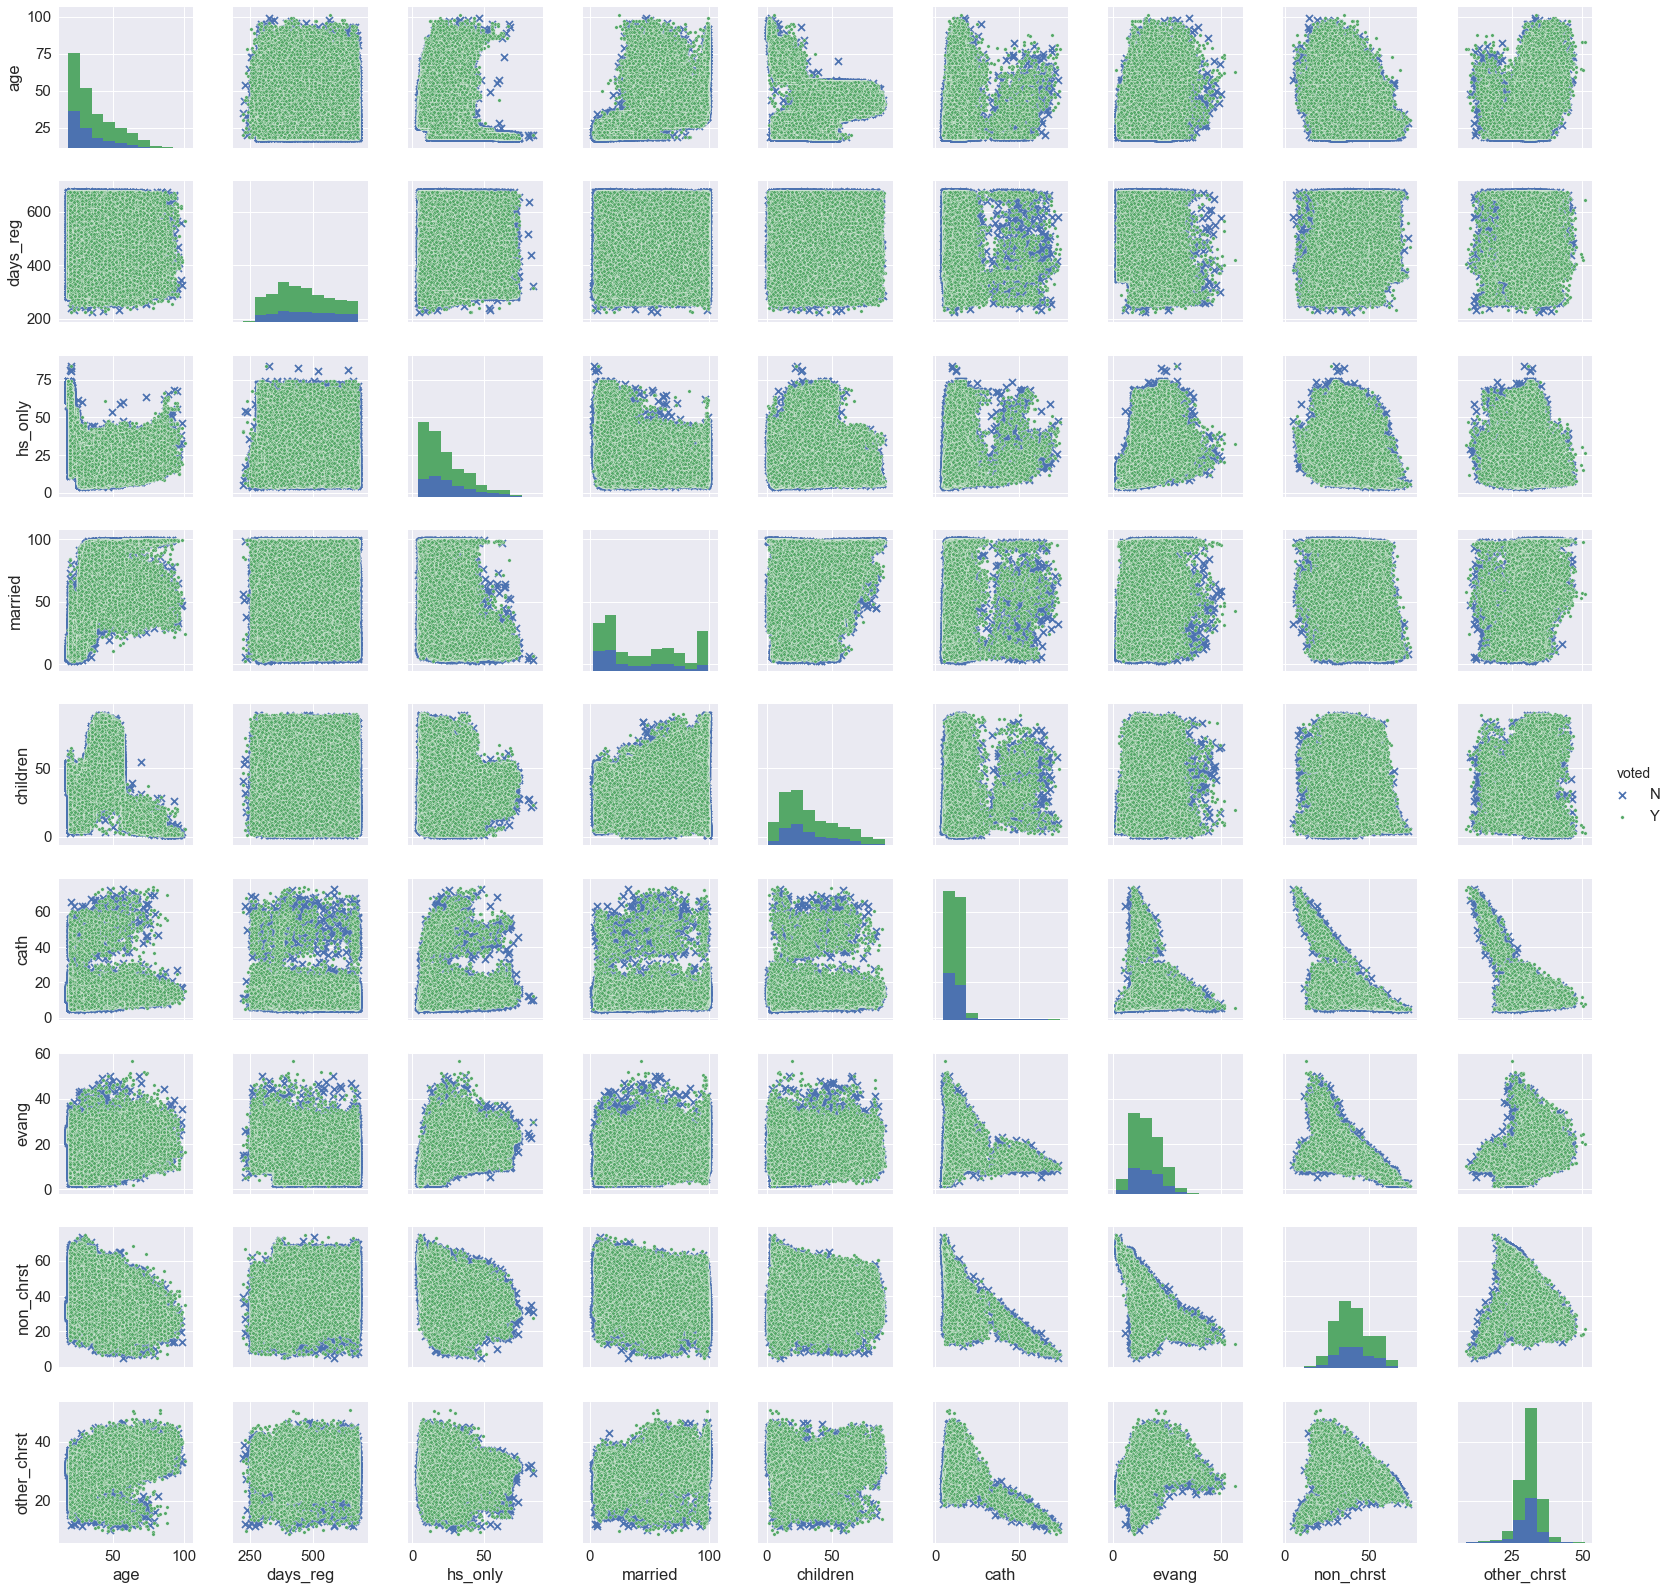

In [177]:
cols = ['voted', 'age', 'days_reg', 'hs_only', 'married', 'children', 'cath',
       'evang', 'non_chrst', 'other_chrst']

p = sns.set(font_scale = 1.5);
p = sns.pairplot(data[cols], markers = ['x', '.'], hue = 'voted', hue_order = ['N', 'Y']);
p
#p.savefig('figure_1.png')

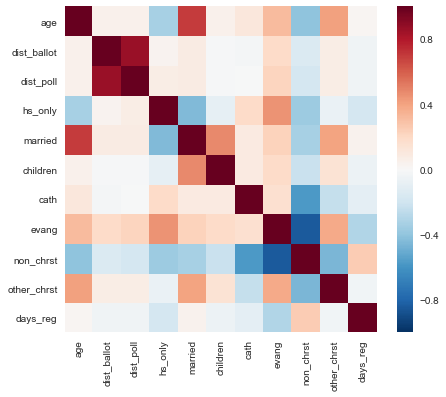

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 6);
sns.heatmap(data.corr());

Although some associations exist (particularly between the religious score variables), none of the relationships can be accurately represented by simple linear fits. Histograms of the individual variables are plotted on the diagonals and colored by whether the individual voted (green) or did not vote (blue). The histograms and pairwise comparisons reveal that the distribution of these predictors is similar between the Y and N groups. The correlation matrix shows expected correlations, e.g., dist_poll and dist_ballot are highly correlated, as are age and likelihood of being married, while likelihood of being non-Christian is anti-correlated with likelihood of being some form of Christian. Most other pair-wise correlations appear relatively weak.

Let's examine the breakdown of the categorical variables by voter response.

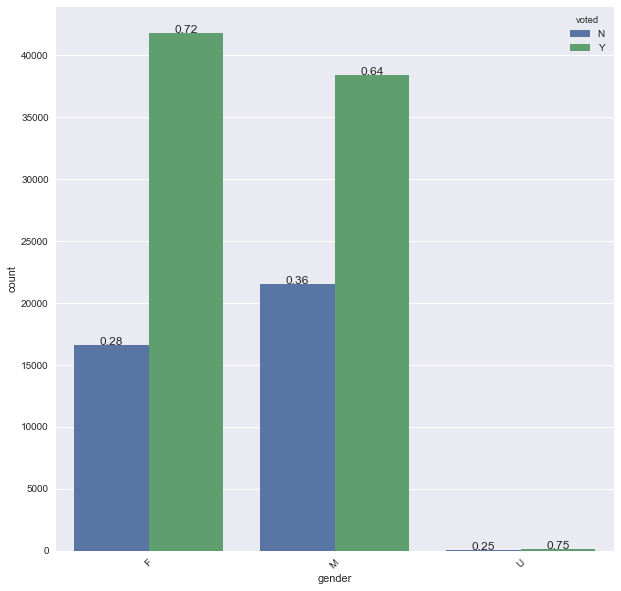

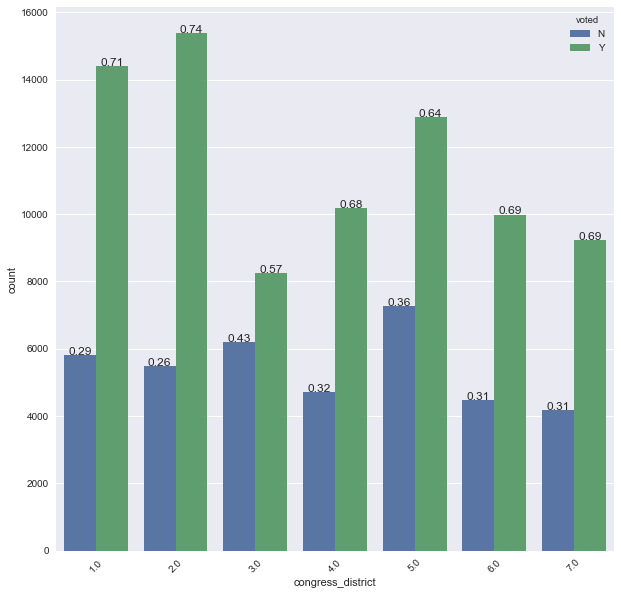

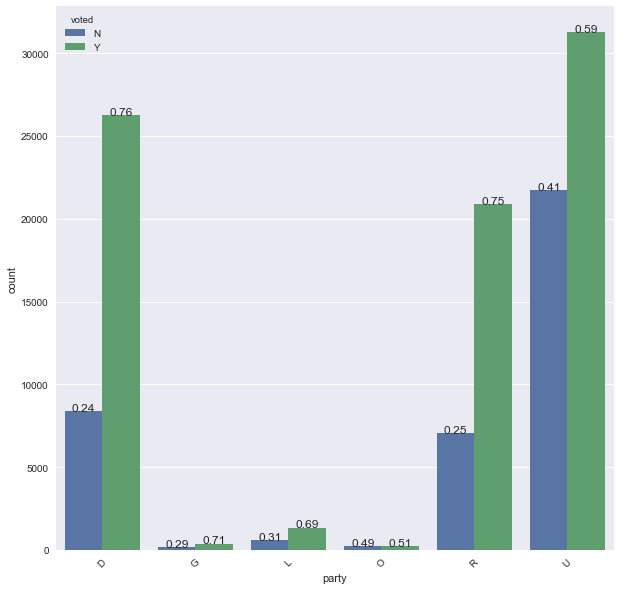

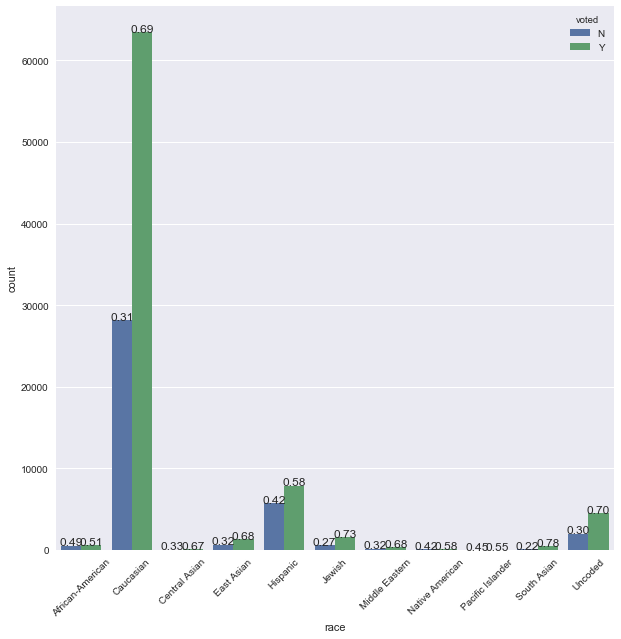

In [44]:
categ_cols = ['gender', 'congress_district', 'party', 'race']
for idx, col in enumerate(categ_cols):
    fig = wv.plot_categ_by_voted(data, col)
    fig;
    #fig.get_figure().savefig('figure_{}.png'.format(idx))

For most of the categories in each nominal variable, the ratio of those who did and did not vote were between 3:1 and 2:1. For example, ~72% of women and ~64% of men voted in Colorado in 2016, thus the likelihood of an individual voting given their gender alone is similar.

There are too many levels in state_house to plot all of them on a single plot. Therefore let's split the state_house variable into smaller sections.

In [45]:
##Plots all state house districts grouped into positive and negative response

#lows = ['0', '16', '23', '30', '38', '45', '52', '6']
#highs = ['17', '24', '31', '39', '46', '53', '60', '99']

#for low, high in zip(lows, highs):
    #wv.plot_categ_by_voted(wv.split_df(data, low, high), 'state_house', col_response = 'voted')

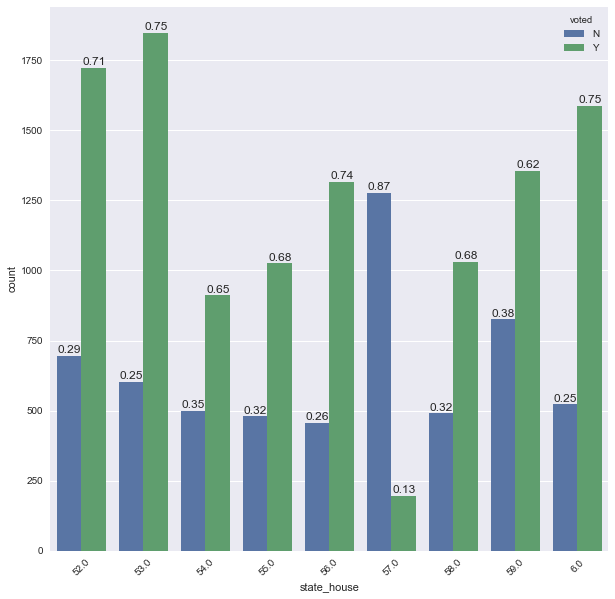

In [22]:
wv.plot_categ_by_voted(wv.split_df(data, '52', '60'), 'state_house')

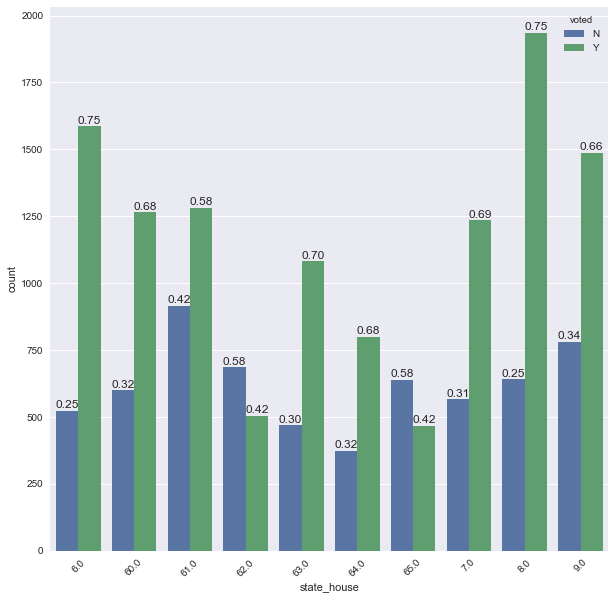

In [23]:
wv.plot_categ_by_voted(wv.split_df(data, '6', '99'), 'state_house')

Most of the individual state house districts also have a 3:1 ratio of vote:no vote, though there are a few districts where the proportion of people who did not vote was higher than those who did vote.

We can also look at what proportion of people who did or did not vote fell into a particular category.

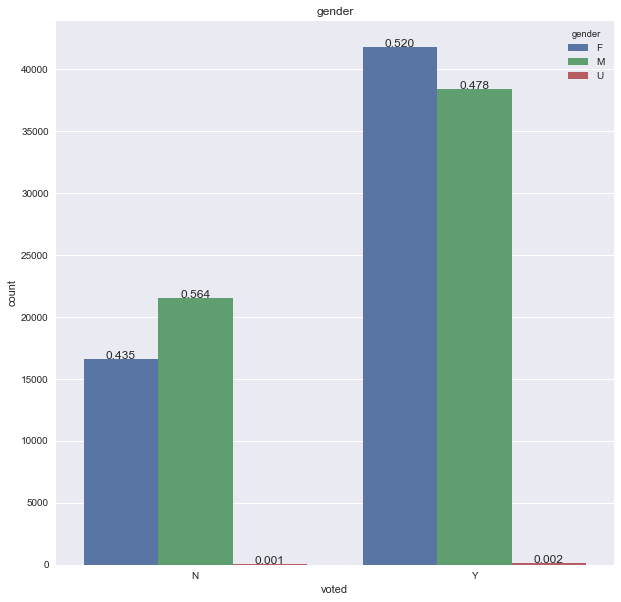

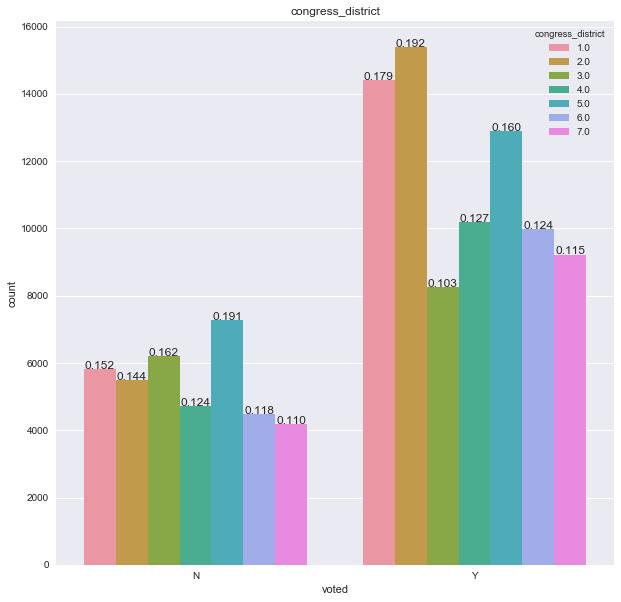

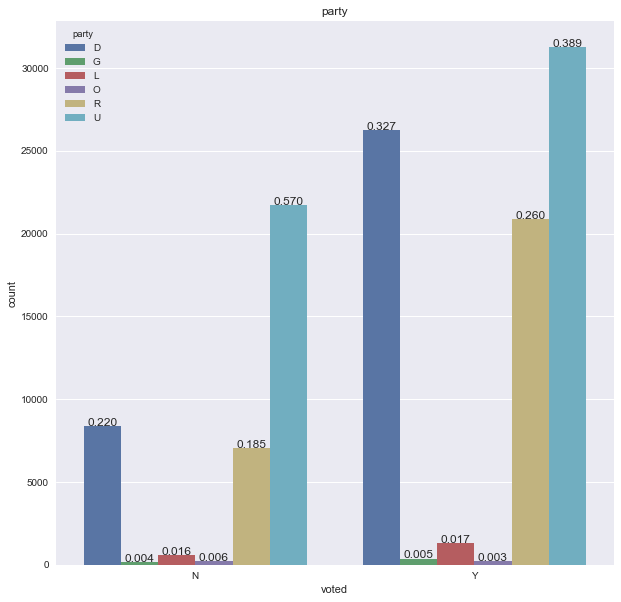

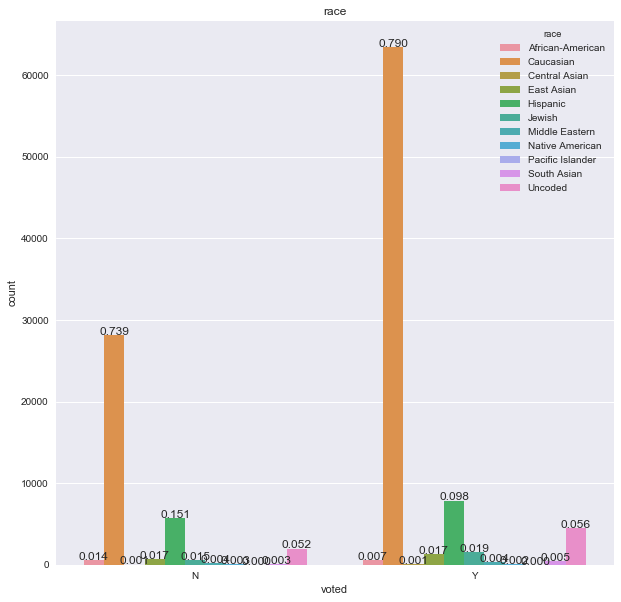

In [344]:
for idx, col in enumerate(categ_cols):
    fig = wv.plot_voted_by_categ(data, col)
    #fig.get_figure().savefig('fig_{}.png'.format(idx))

In [47]:
#save renamed csv
data.to_csv('train_renamed.csv', index = False)

Initial exploration does not reveal any features that are clearly associated with a positive or negative response. In [part 2](who-voted_features.ipynb) we will explore potentially important features for our predictive task.